# This notebook is for the purpose of model development

## Let's check to see that we can access CUDA GPU acceleration.

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
NVIDIA GeForce RTX 3080 Ti


## All good there. Let's now load our dataset.

In [2]:
# we need our custom class defined for pickle
class SyntheticEventDataset(torch.utils.data.Dataset):
    def __init__(self, csv_folder_path):
        pass
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

class CustomDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        data, target = self.original_dataset[idx]
        
        # Unsqueeze the feature tensor to add the last dimension
        data = data.unsqueeze(-1)  # Add dimension at the end to make it (27500, 1)
        
        return data, target

train_dataset = torch.load('PyTorch_Synthetic_Data/train_data_cm.pt', weights_only=False)
val_dataset = torch.load('PyTorch_Synthetic_Data/validation_data_cm.pt', weights_only=False)
test_dataset = torch.load('PyTorch_Synthetic_Data/test_data_cm.pt', weights_only=False)

In [3]:
class SubsetDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, indices):
        self.original_dataset = original_dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.original_dataset[self.indices[idx]]

# Define the indices for the first 1000 elements
subset_indices = list(range(10000))

# Create a subset of train_dataset_cm
train_dataset_subset = SubsetDataset(train_dataset, subset_indices)

## With the dataset read in, let's define some DataLoaders.

In [4]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
sub_loader = DataLoader(train_dataset_subset, batch_size=batch_size, shuffle=True)

# Here we can see that our data is loading correctly
X, y = next(iter(train_loader))
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([32, 27500, 1])
Target shape: torch.Size([32, 4])


## Excellent, with the data handling steps in place we can move on to building the neural net.

In [50]:
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, input_size, lstm_hidden_units, dense_sizes, dropout_prob):
        super(CustomModel, self).__init__()
        
        # Initial convolutional layer with 8 out_channels, kernel size 64, linear activation
        self.conv1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=8,
            kernel_size=64,
            stride=1,
            padding=32  # To keep the output size the same (valid padding)
        )
        self.conv1_activation = nn.Identity()  # Linear activation, no change
        
        # Convolutional layers with 8 out_channels, kernel size 32, ReLU activation
        self.conv2 = nn.Conv1d(
            in_channels=8,
            out_channels=8,
            kernel_size=32,
            stride=1,
            padding=16  # To keep output size the same
        )
        self.conv2_activation = nn.ReLU()
        
        self.conv3 = nn.Conv1d(
            in_channels=8,
            out_channels=8,
            kernel_size=32,
            stride=1,
            padding=16  # To keep output size the same
        )
        self.conv3_activation = nn.ReLU()
        
        # Flatten, Batch Normalization and Max Pooling layers
        self.flatten = nn.Flatten()
        self.batch_norm = nn.BatchNorm1d(8)
        self.max_pool = nn.MaxPool1d(kernel_size=3)
        
        # Repeating the 2 convolution + batch normalization + max pooling sequence
        self.conv4 = nn.Conv1d(
            in_channels=8,
            out_channels=8,
            kernel_size=32,
            stride=1,
            padding=16
        )
        self.conv4_activation = nn.ReLU()
        
        self.conv5 = nn.Conv1d(
            in_channels=8,
            out_channels=8,
            kernel_size=32,
            stride=1,
            padding=16
        )
        self.conv5_activation = nn.ReLU()
        
        # Second sequence of Batch Normalization and Max Pooling
        self.batch_norm2 = nn.BatchNorm1d(8)
        
        # Final convolution layer with 16 out_channels, kernel size 16, linear activation
        self.conv6 = nn.Conv1d(
            in_channels=8,
            out_channels=16,
            kernel_size=16,
            stride=1,
            padding=8  # To keep output size the same
        )
        self.conv6_activation = nn.Identity()  # Linear activation, no change
        
        # Max Pooling after the last convolution
        self.max_pool2 = nn.MaxPool1d(kernel_size=3)
        
        # Bi-directional LSTM layer with 8 hidden units
        self.lstm = nn.LSTM(
            input_size=16,  # The output of the last conv layer (16 channels)
            hidden_size=lstm_hidden_units,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        
        # Flatten after LSTM and fully connected layers with decreasing size
        self.fc1 = nn.Linear(lstm_hidden_units * 2, dense_sizes[0])  # *2 for bidirectional
        self.fc2 = nn.Linear(dense_sizes[0], dense_sizes[1])
        self.fc3 = nn.Linear(dense_sizes[1], dense_sizes[2])
        self.fc4 = nn.Linear(dense_sizes[2], dense_sizes[3])
        self.output = nn.Linear(dense_sizes[3], 4)  # Output single feature
        
        # ReLU activations for dense layers (except the last one)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # Ensure the input shape is [batch_size, in_channels, seq_length]
        x = x.transpose(1, 2)  # [batch_size, 1, seq_length]
        
        # Initial convolution and activation
        x = self.conv1(x)
        x = self.conv1_activation(x)  # Linear, no activation change
        
        # First set of convolutions with ReLU activations
        x = self.conv2(x)
        x = self.conv2_activation(x)
        x = self.conv3(x)
        x = self.conv3_activation(x)
        
        # Batch normalization and max pooling
        x = self.max_pool(x)
        x = self.batch_norm(x)
        
        # Second set of convolutions with ReLU activations
        x = self.conv4(x)
        x = self.conv4_activation(x)
        x = self.conv5(x)
        x = self.conv5_activation(x)
        
        # Batch normalization and max pooling
        x = self.max_pool(x)
        x = self.batch_norm2(x)
        
        # Final convolution with linear activation and max pooling
        x = self.conv6(x)
        x = self.conv6_activation(x)  # Linear, no activation change
        x = self.max_pool2(x)
        
        # Prepare data for LSTM: reshape to [batch_size, seq_len, input_size]
        x = x.transpose(1, 2)  # LSTM expects [batch_size, seq_len, input_size]
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Get the last hidden state (forward and backward for bidirectional)
        last_hidden_state = torch.cat((h_n[-2], h_n[-1]), dim=1)  # Shape: (batch_size, hidden_size * 2)
        
        # Dense layers with ReLU activations and dropout
        x = self.relu(self.fc1(last_hidden_state))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)  # No activation after the last dense layer
        
        # Output layer: final single value prediction
        output = self.output(x)  # Shape: (batch_size, 1)
        #output = output.squeeze(1)
        return output

# Example initialization
model = CustomModel(
    input_size=1,                # Feature size (e.g., raw strain data per timestep) 
    lstm_hidden_units=16,         # LSTM hidden units
    dense_sizes=[128, 64, 32, 16], # Sizes of the tapering dense layers
    dropout_prob=0.0             # Dropout probability
)

print(model)
print(f"Num of params:{sum(p.numel() for p in model.parameters())}")

CustomModel(
  (conv1): Conv1d(1, 8, kernel_size=(64,), stride=(1,), padding=(32,))
  (conv1_activation): Identity()
  (conv2): Conv1d(8, 8, kernel_size=(32,), stride=(1,), padding=(16,))
  (conv2_activation): ReLU()
  (conv3): Conv1d(8, 8, kernel_size=(32,), stride=(1,), padding=(16,))
  (conv3_activation): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (batch_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(8, 8, kernel_size=(32,), stride=(1,), padding=(16,))
  (conv4_activation): ReLU()
  (conv5): Conv1d(8, 8, kernel_size=(32,), stride=(1,), padding=(16,))
  (conv5_activation): ReLU()
  (batch_norm2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv1d(8, 16, kernel_size=(16,), stride=(1,), padding=(8,))
  (conv6_activation): Identity()
  (max_pool2): MaxPool1d(kernel_size=3, stride=3, pad

## Define the hyper parameters for our model

In [51]:
learning_rate = 1e-5

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Define the training and validation loop

In [52]:
import time
from tqdm import tqdm

def train_model(data_loader, model, loss_function, optimizer, device="cuda"):
    """
    Train the model for one epoch.

    Args:
        data_loader (DataLoader): DataLoader for the training data.
        model (nn.Module): The PyTorch model to train.
        loss_function (nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        device (str): Device to use ('cpu' or 'cuda').
    """
    model.train()
    total_loss = 0
    num_batches = len(data_loader)

    progress_bar = tqdm(data_loader, desc="Training", leave=False)

    for X, y in progress_bar:
        # Move data and target to the specified device
        X, y = X.to(device), y.to(device)

        # Forward pass
        output = model(X)
        loss = loss_function(output, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss
        total_loss += loss.item()

        # Update progress bar with the current loss
        progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / num_batches
    #print(f"Train loss: {avg_loss:.4f}")
    return avg_loss

def validate_model(data_loader, model, loss_function, device="cuda"):
    """
    Evaluate the model on the test/validation data.

    Args:
        data_loader (DataLoader): DataLoader for the test/validation data.
        model (nn.Module): The PyTorch model to evaluate.
        loss_function (nn.Module): The loss function.
        device (str): Device to use ('cpu' or 'cuda').
    """
    model.eval()
    total_loss = 0
    num_batches = len(data_loader)

    progress_bar = tqdm(data_loader, desc="Validating", leave=False)

    with torch.no_grad():
        for X, y in progress_bar:
            # Move data and target to the specified device
            X, y = X.to(device), y.to(device)

            # Forward pass
            output = model(X)
            loss = loss_function(output, y)

            # Track loss
            total_loss += loss.item()

            # Update progress bar with the current loss
            progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / num_batches
    #print(f"Validation loss: {avg_loss:.4f}")
    return avg_loss

Epoch 0
---------


Train Loss: 1522407.6633 -|- Validation Loss: 1508801.8596 -|- Epoch Time: 47.6306 seconds


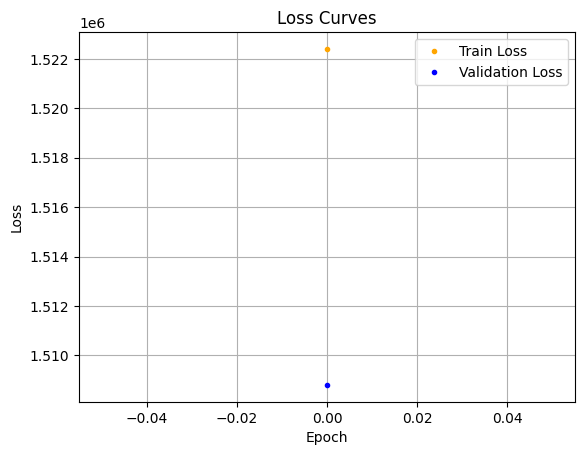


Epoch 1
---------


Train Loss: 1437916.3903 -|- Validation Loss: 1325627.1302 -|- Epoch Time: 47.8445 seconds


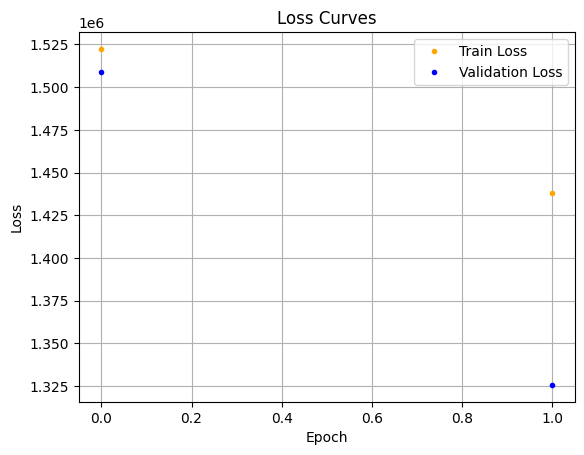


Epoch 2
---------


Train Loss: 1115246.5218 -|- Validation Loss: 864338.3836 -|- Epoch Time: 47.8144 seconds


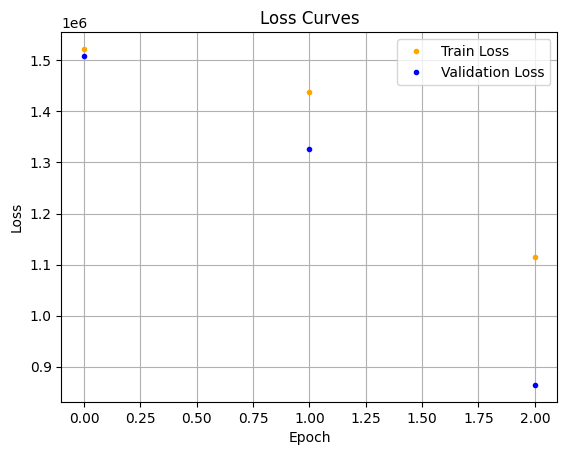


Epoch 3
---------


Train Loss: 594079.2418 -|- Validation Loss: 362112.7253 -|- Epoch Time: 47.8153 seconds


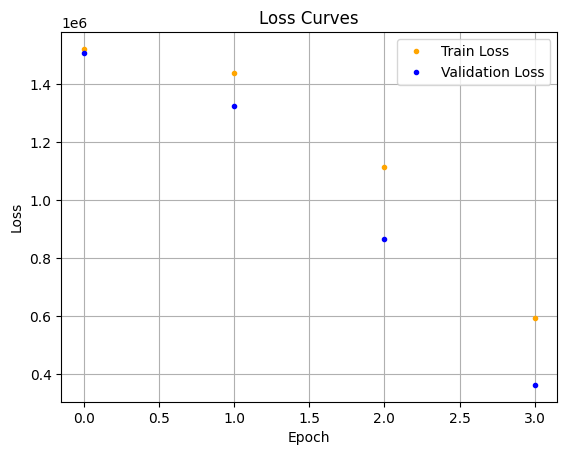


Epoch 4
---------


Train Loss: 234660.9393 -|- Validation Loss: 175015.9391 -|- Epoch Time: 48.0000 seconds


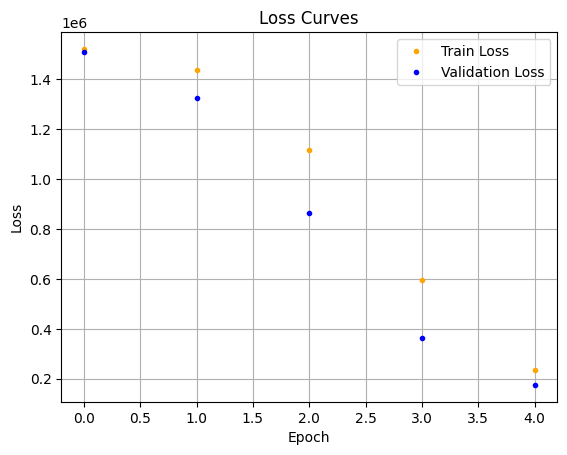


Epoch 5
---------


Train Loss: 163856.4888 -|- Validation Loss: 163001.9022 -|- Epoch Time: 47.9898 seconds


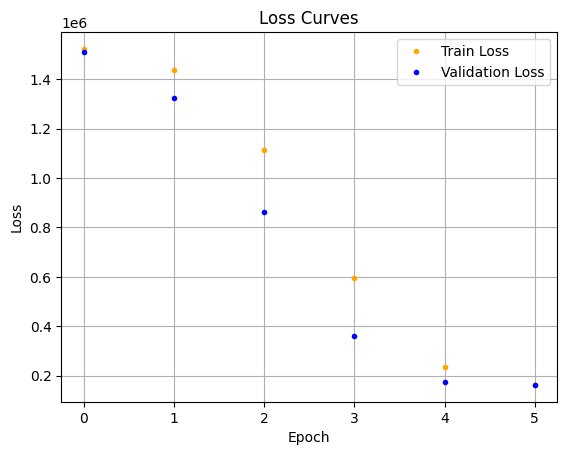


Epoch 6
---------


Train Loss: 160372.4848 -|- Validation Loss: 164072.8137 -|- Epoch Time: 47.9964 seconds


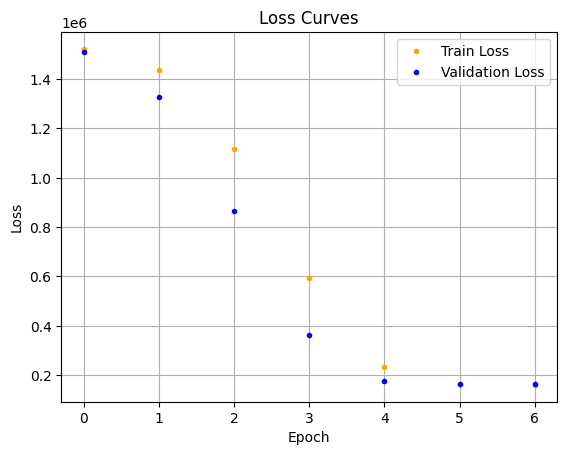


Epoch 7
---------


Train Loss: 159306.1927 -|- Validation Loss: 161128.8135 -|- Epoch Time: 47.9947 seconds


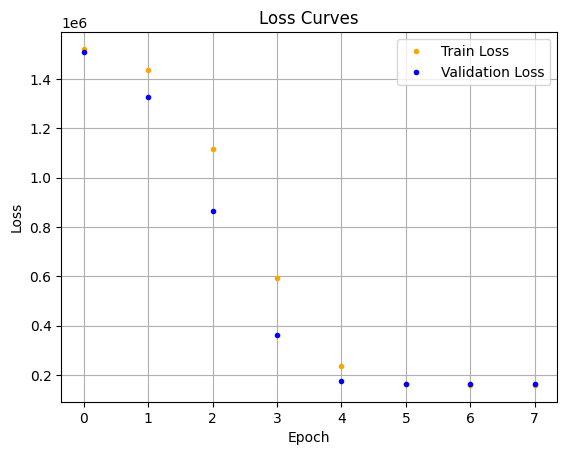


Epoch 8
---------


Train Loss: 158218.8074 -|- Validation Loss: 160408.8541 -|- Epoch Time: 47.9961 seconds


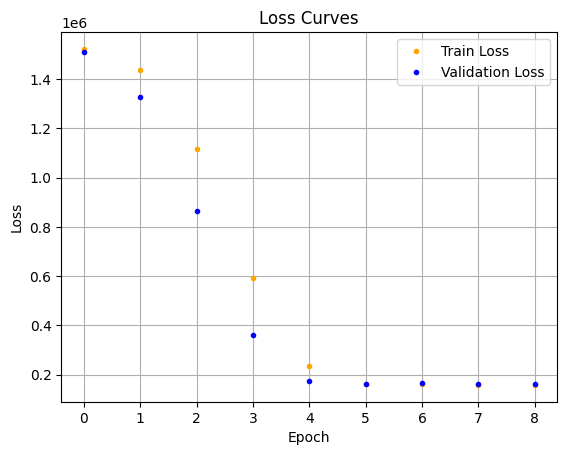


Epoch 9
---------


Train Loss: 157432.5007 -|- Validation Loss: 159235.9538 -|- Epoch Time: 47.9945 seconds


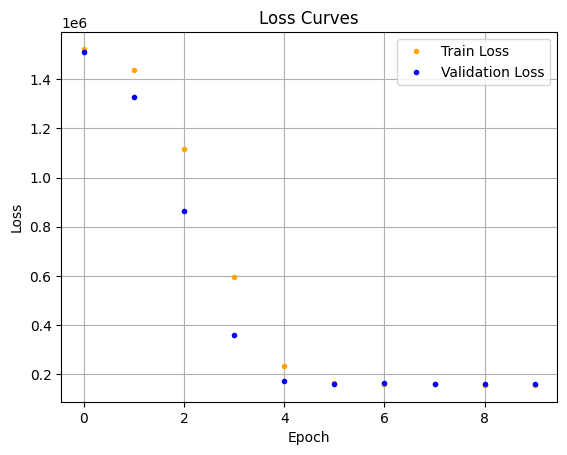


Epoch 10
---------


Train Loss: 156914.8718 -|- Validation Loss: 159046.4904 -|- Epoch Time: 47.9942 seconds


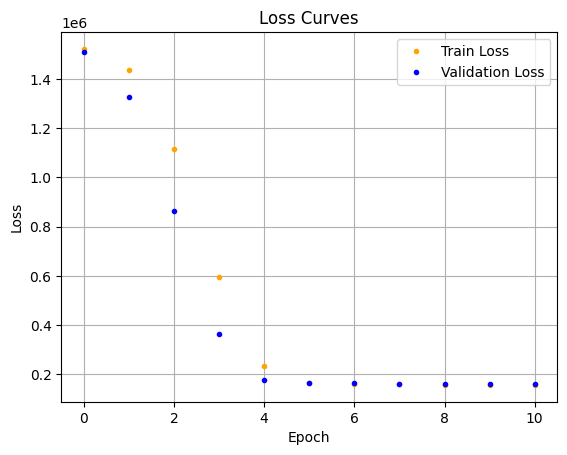


Epoch 11
---------


Train Loss: 156359.2461 -|- Validation Loss: 159027.7045 -|- Epoch Time: 48.0090 seconds


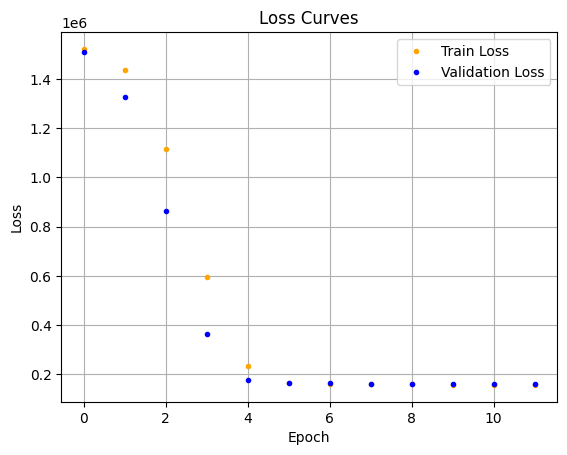


Epoch 12
---------


Train Loss: 155966.6568 -|- Validation Loss: 159040.9755 -|- Epoch Time: 48.0065 seconds


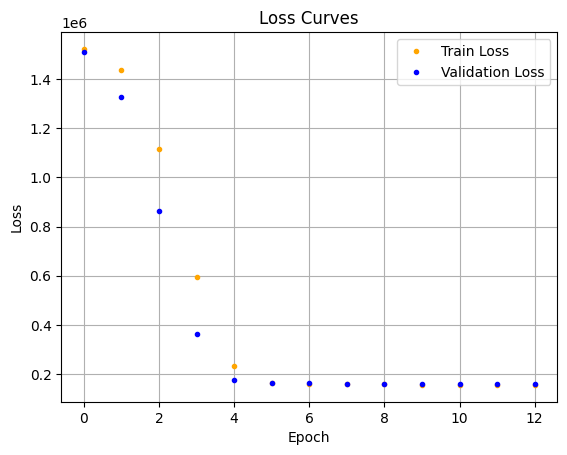


Epoch 13
---------


Train Loss: 155725.2313 -|- Validation Loss: 158971.6664 -|- Epoch Time: 48.0152 seconds


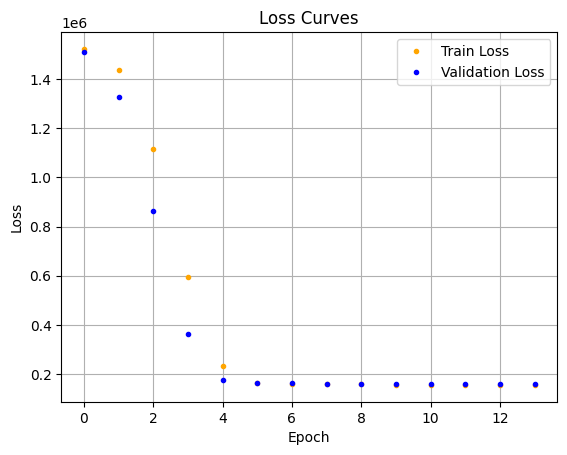


Epoch 14
---------


Train Loss: 155397.9695 -|- Validation Loss: 157603.9688 -|- Epoch Time: 48.0143 seconds


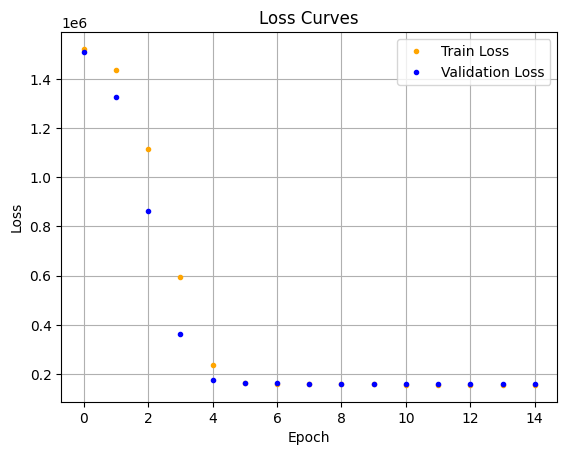


Epoch 15
---------


Train Loss: 155043.6400 -|- Validation Loss: 157721.8617 -|- Epoch Time: 47.9973 seconds


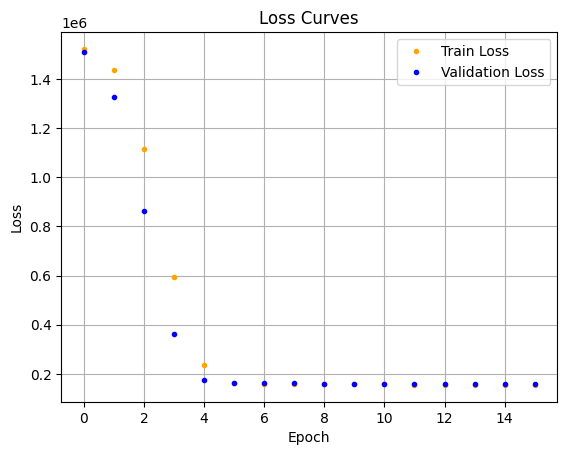


Epoch 16
---------


Train Loss: 154914.4437 -|- Validation Loss: 157796.2517 -|- Epoch Time: 47.9926 seconds


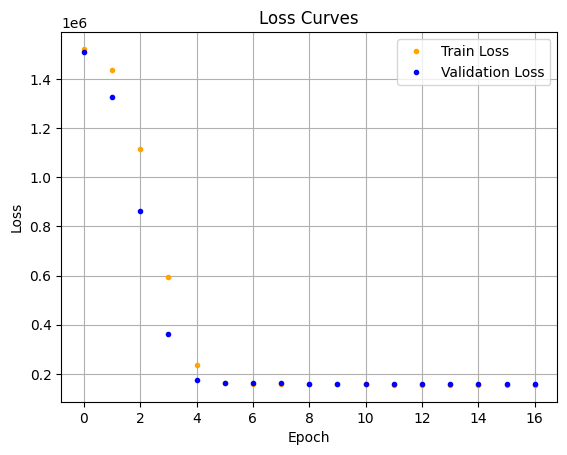


Epoch 17
---------


Train Loss: 154713.8530 -|- Validation Loss: 156892.7787 -|- Epoch Time: 47.9919 seconds


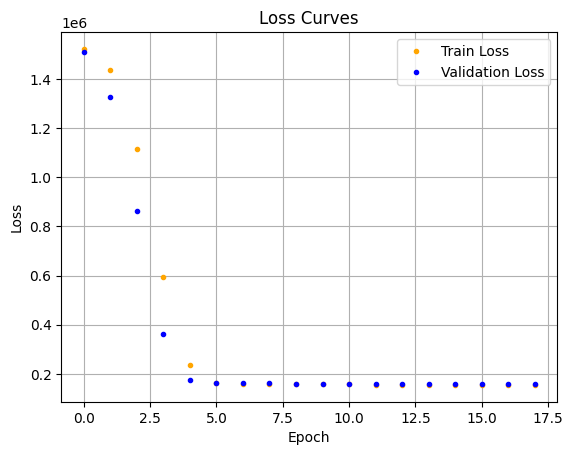


Epoch 18
---------


Train Loss: 154367.2524 -|- Validation Loss: 156938.1353 -|- Epoch Time: 47.9907 seconds


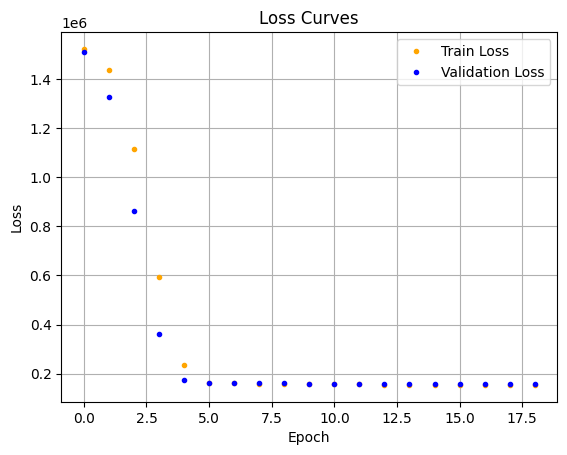


Epoch 19
---------


Train Loss: 154129.3604 -|- Validation Loss: 156802.8247 -|- Epoch Time: 47.9970 seconds


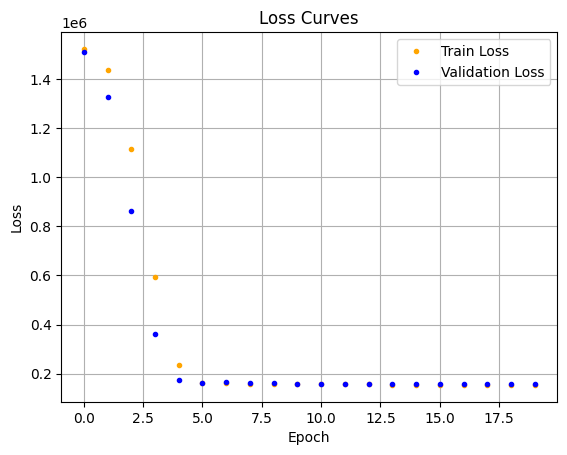


Epoch 20
---------


Train Loss: 153934.3108 -|- Validation Loss: 156529.6950 -|- Epoch Time: 47.9998 seconds


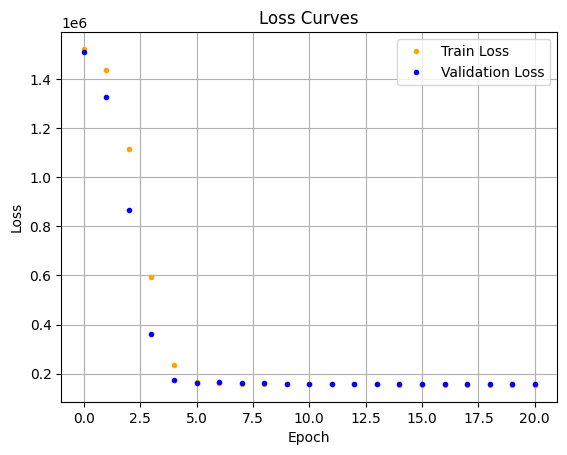


Epoch 21
---------


Train Loss: 153652.9576 -|- Validation Loss: 157226.2943 -|- Epoch Time: 48.0174 seconds


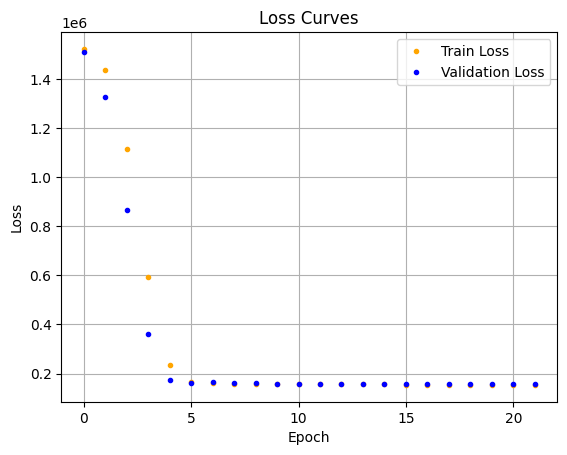


Epoch 22
---------


Train Loss: 153309.5913 -|- Validation Loss: 157927.2512 -|- Epoch Time: 48.0039 seconds


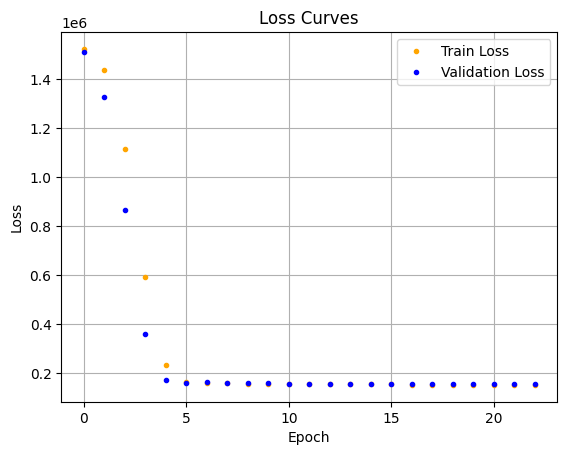


Epoch 23
---------


Train Loss: 153344.7815 -|- Validation Loss: 156333.1958 -|- Epoch Time: 48.0042 seconds


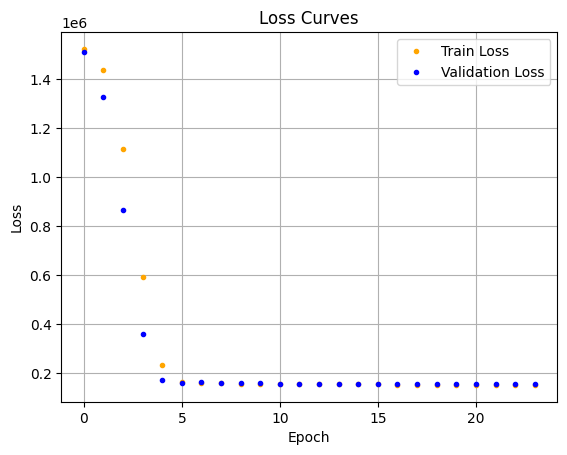


Epoch 24
---------


Train Loss: 152966.1817 -|- Validation Loss: 156608.2995 -|- Epoch Time: 48.0103 seconds


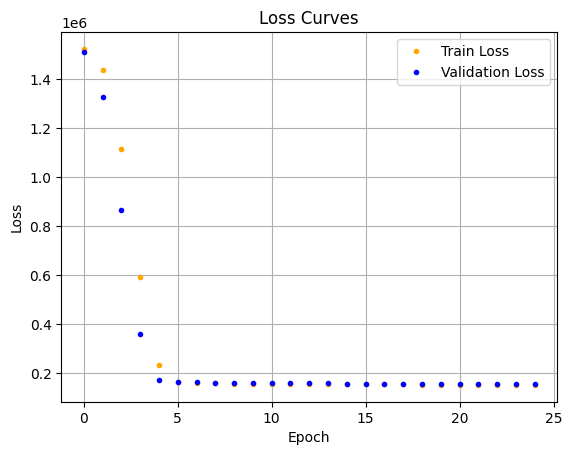


Epoch 25
---------


Train Loss: 152718.4791 -|- Validation Loss: 156998.4389 -|- Epoch Time: 48.0203 seconds


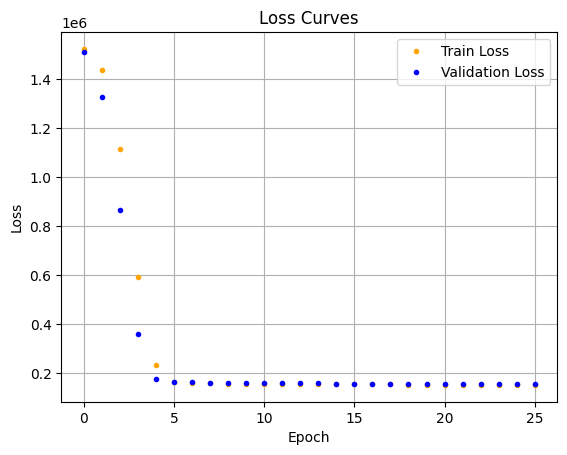


Epoch 26
---------


Train Loss: 152605.0185 -|- Validation Loss: 156304.6963 -|- Epoch Time: 48.0179 seconds


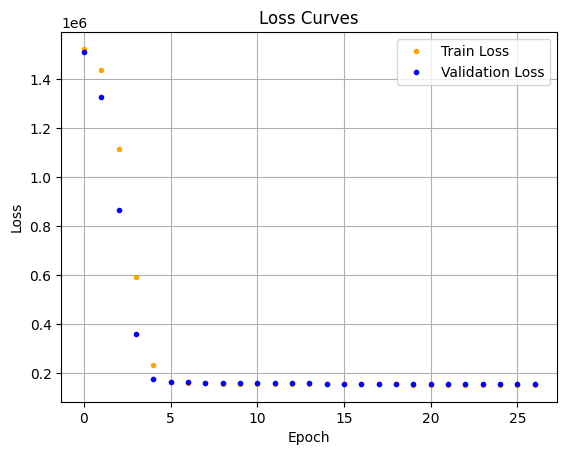


Epoch 27
---------


Train Loss: 152404.5632 -|- Validation Loss: 156706.3385 -|- Epoch Time: 48.0360 seconds


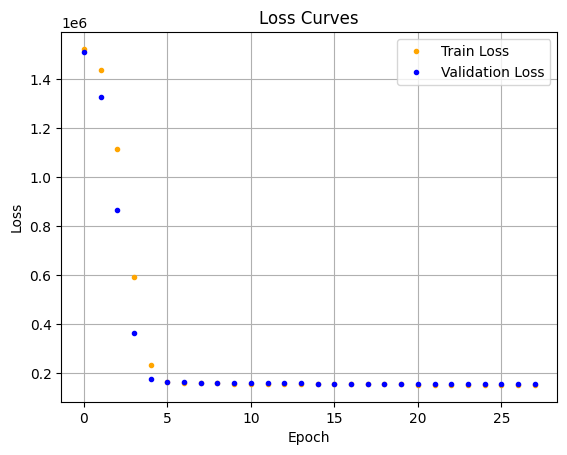


Epoch 28
---------


Train Loss: 152076.3692 -|- Validation Loss: 156318.6633 -|- Epoch Time: 48.0199 seconds


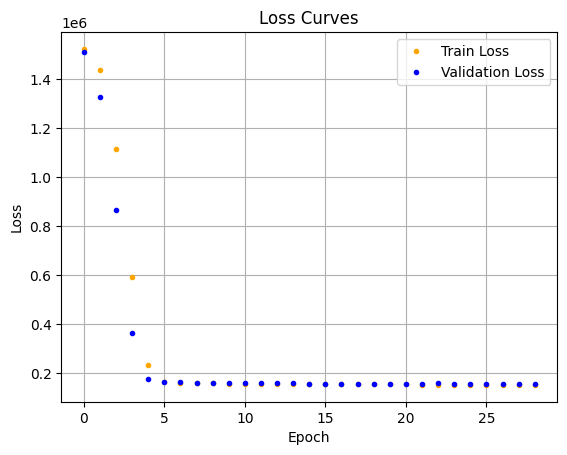


Epoch 29
---------


Train Loss: 152067.4489 -|- Validation Loss: 157785.3378 -|- Epoch Time: 48.0285 seconds


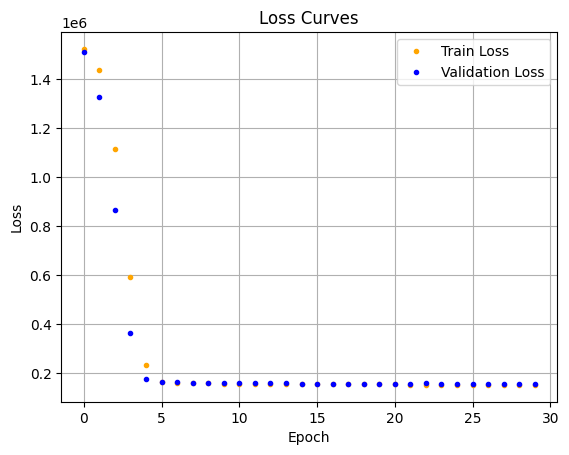


Epoch 30
---------


Train Loss: 151687.2803 -|- Validation Loss: 156480.8405 -|- Epoch Time: 47.9880 seconds


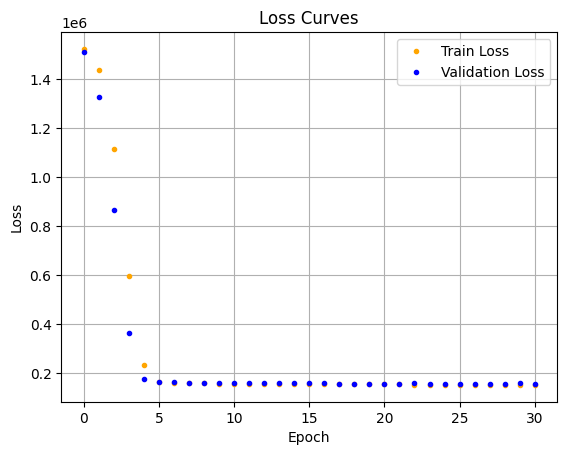


Epoch 31
---------


Train Loss: 151475.3941 -|- Validation Loss: 156129.1875 -|- Epoch Time: 47.9690 seconds


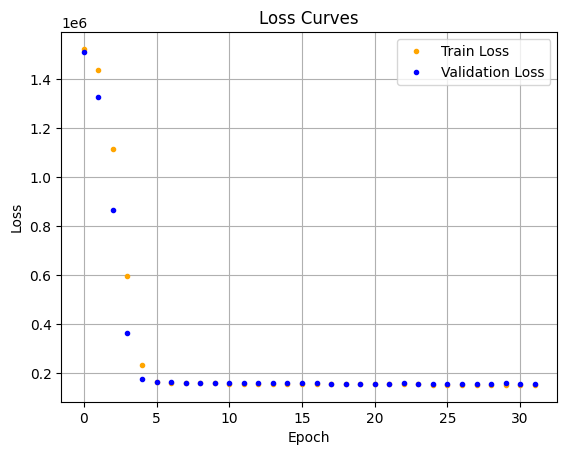


Epoch 32
---------


Train Loss: 151506.6493 -|- Validation Loss: 156253.4398 -|- Epoch Time: 47.9581 seconds


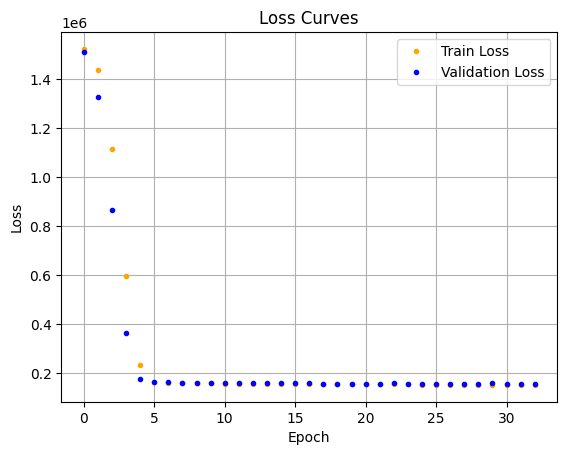


Epoch 33
---------


Train Loss: 151265.2303 -|- Validation Loss: 155267.4032 -|- Epoch Time: 47.9431 seconds


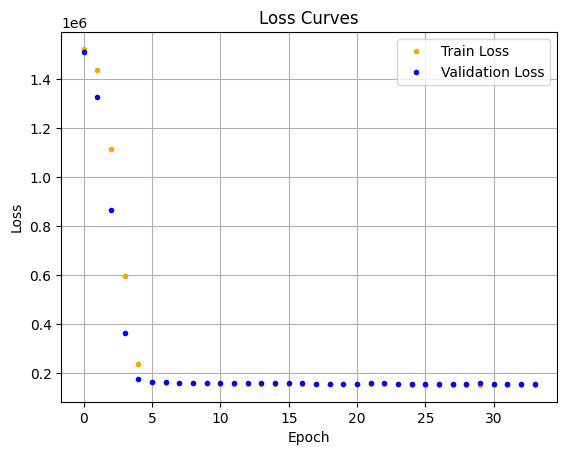


Epoch 34
---------


Train Loss: 151053.0829 -|- Validation Loss: 156058.5314 -|- Epoch Time: 47.9453 seconds


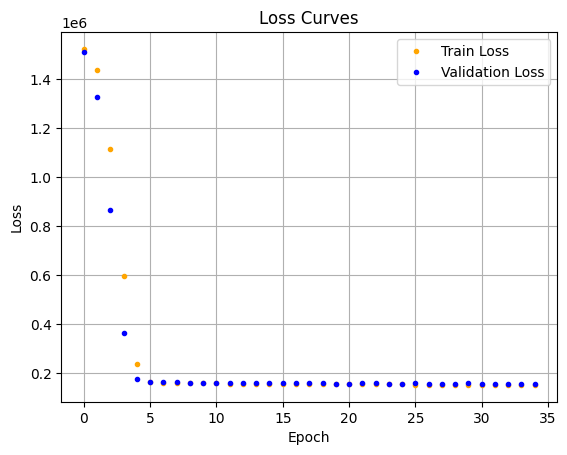


Epoch 35
---------


Train Loss: 151014.0584 -|- Validation Loss: 155667.7968 -|- Epoch Time: 47.9414 seconds


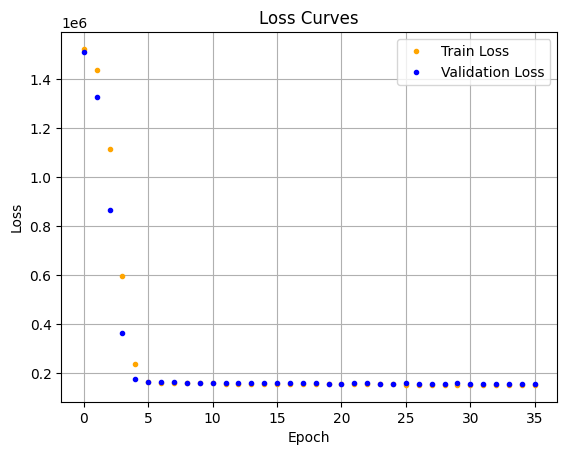


Epoch 36
---------


Train Loss: 150890.8294 -|- Validation Loss: 156474.0275 -|- Epoch Time: 47.9732 seconds


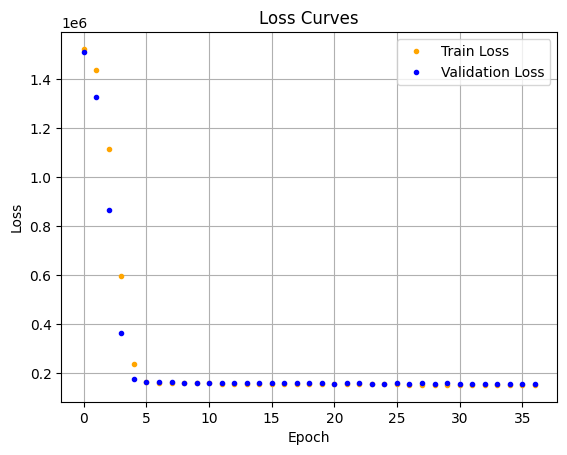


Epoch 37
---------


Train Loss: 151314.9198 -|- Validation Loss: 155377.4914 -|- Epoch Time: 48.0038 seconds


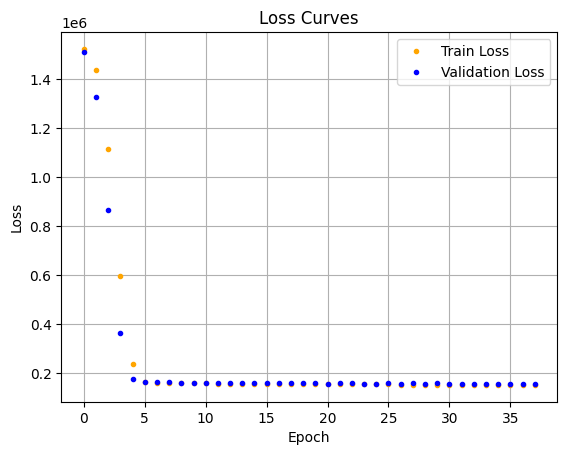


Epoch 38
---------


Train Loss: 150462.6097 -|- Validation Loss: 155552.8417 -|- Epoch Time: 48.0387 seconds


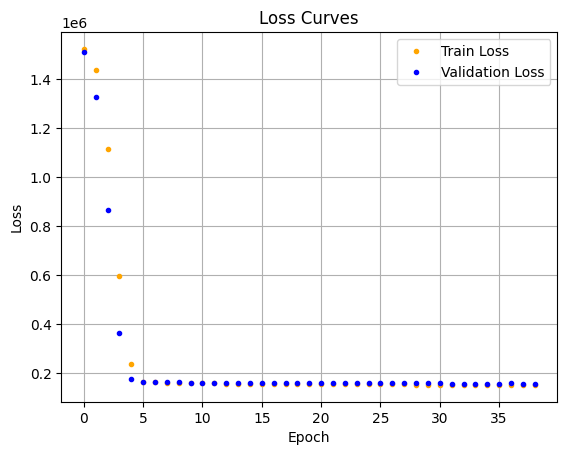


Epoch 39
---------


Train Loss: 150489.0788 -|- Validation Loss: 155803.5540 -|- Epoch Time: 48.5324 seconds


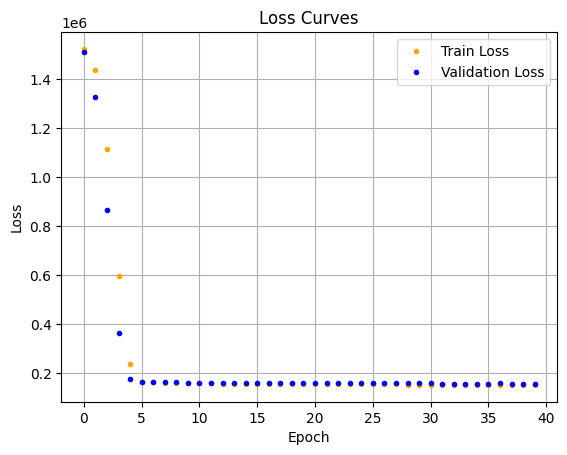


Epoch 40
---------


Train Loss: 150490.7496 -|- Validation Loss: 156267.0783 -|- Epoch Time: 48.2001 seconds


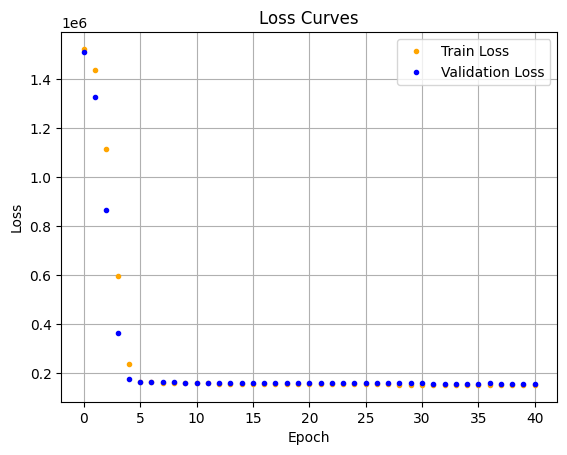


Epoch 41
---------


Train Loss: 150276.3560 -|- Validation Loss: 156160.5703 -|- Epoch Time: 48.0565 seconds


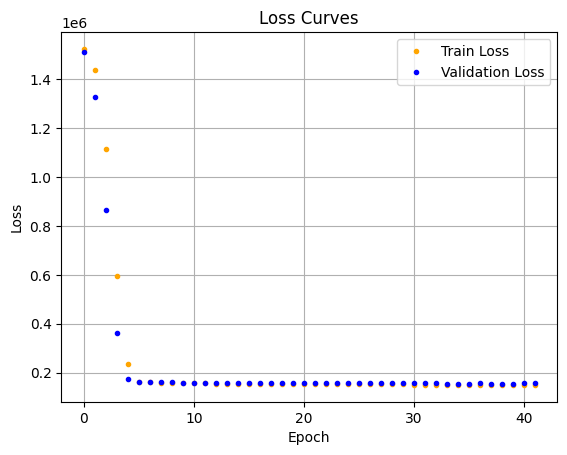


Epoch 42
---------


Train Loss: 150124.1742 -|- Validation Loss: 158454.9231 -|- Epoch Time: 48.0717 seconds


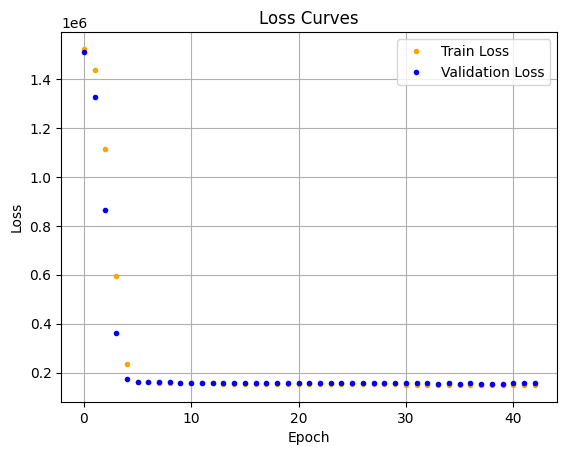


Epoch 43
---------


Train Loss: 150060.6758 -|- Validation Loss: 155513.3572 -|- Epoch Time: 48.0757 seconds


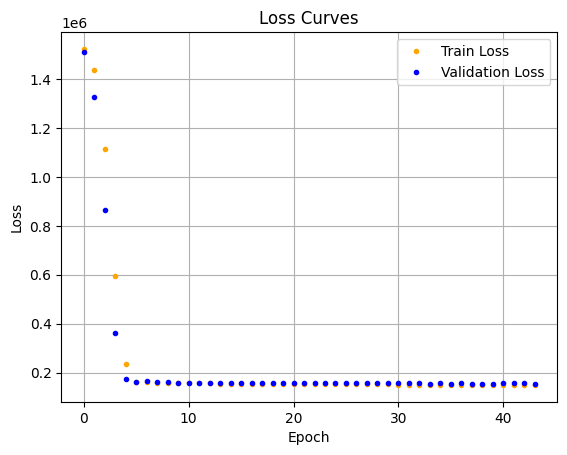


Epoch 44
---------


Train Loss: 149848.2683 -|- Validation Loss: 155338.5775 -|- Epoch Time: 48.0765 seconds


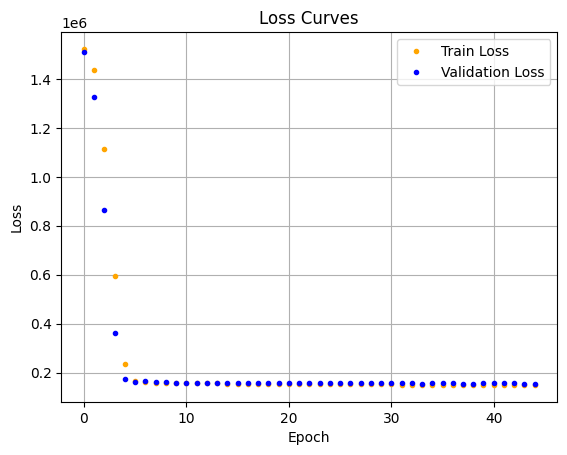


Epoch 45
---------


Train Loss: 149727.0550 -|- Validation Loss: 155691.0154 -|- Epoch Time: 48.0863 seconds


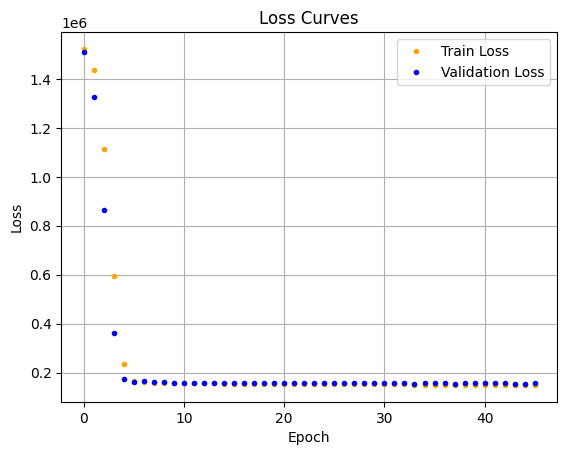


Epoch 46
---------


Train Loss: 149639.4791 -|- Validation Loss: 155088.7479 -|- Epoch Time: 48.0750 seconds


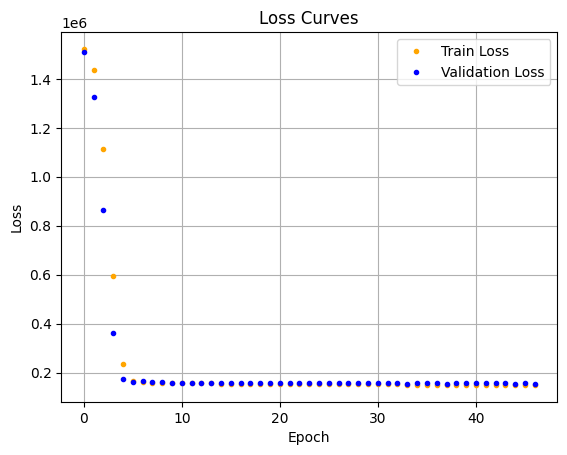


Epoch 47
---------


Train Loss: 149554.1166 -|- Validation Loss: 155043.1031 -|- Epoch Time: 48.0906 seconds


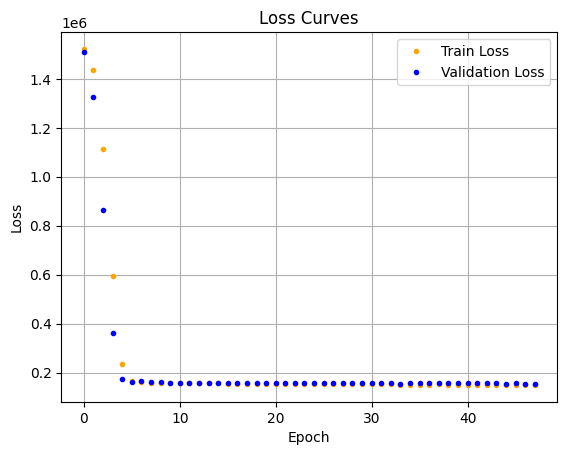


Epoch 48
---------


Train Loss: 145851.4550 -|- Validation Loss: 156668.0514 -|- Epoch Time: 48.1509 seconds


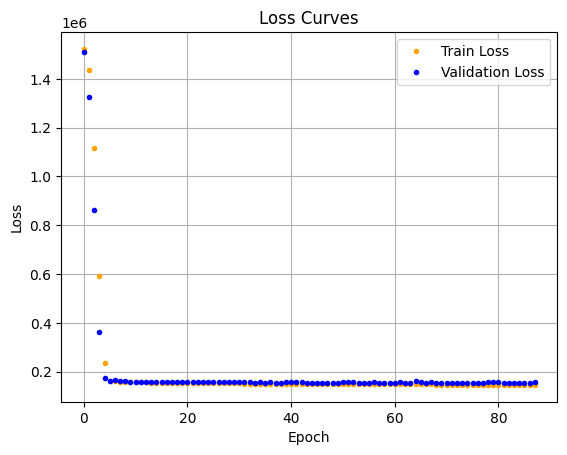


Epoch 88
---------


Training:  50%|██████████████████████████████████████████████████████▉                                                        | 1085/2190 [00:22<00:22, 48.99it/s, Batch Loss=1.46e+5]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Train Loss: 145147.2974 -|- Validation Loss: 155269.6485 -|- Epoch Time: 48.1569 seconds


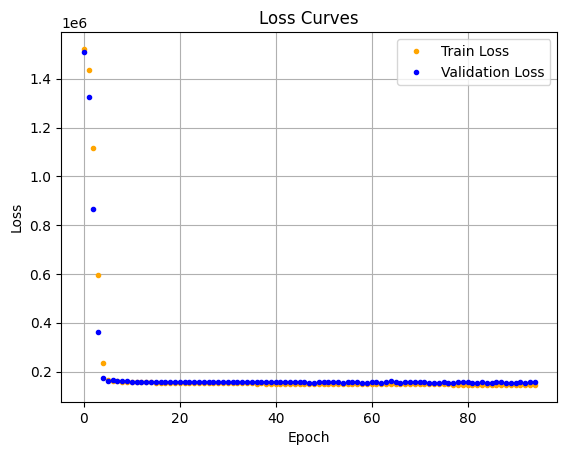


Epoch 95
---------


Train Loss: 145001.7835 -|- Validation Loss: 153929.9255 -|- Epoch Time: 48.1381 seconds


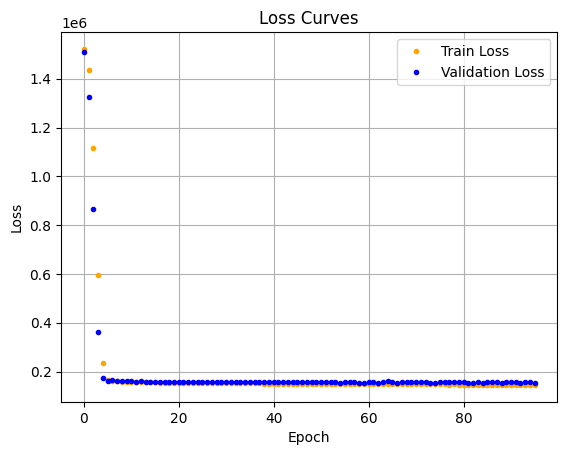


Epoch 96
---------


Train Loss: 144989.5304 -|- Validation Loss: 154383.9527 -|- Epoch Time: 48.1036 seconds


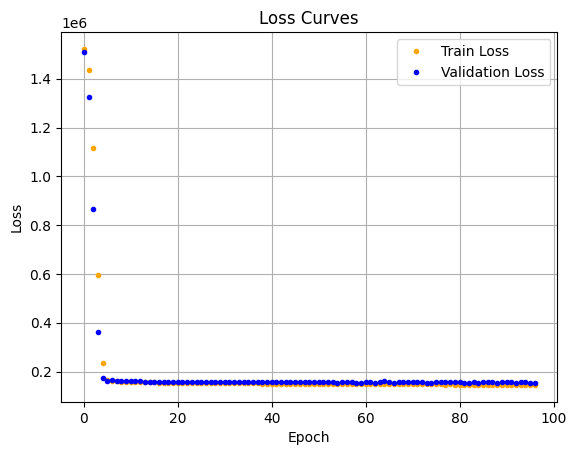


Epoch 97
---------


Training:  25%|███████████████████████████▌                                                                                    | 540/2190 [00:11<00:33, 49.04it/s, Batch Loss=1.53e+5]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [53]:
import numpy as np
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

model = model.to('cuda')

train_loss_list = np.array([])
val_loss_list = np.array([])

for ix_epoch in range(100):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, model, loss_function, optimizer, device='cuda')
    validation_loss = validate_model(val_loader, model, loss_function, device='cuda')
    end = time.time()
    epoch_time = end - start
    train_loss_list = np.append(train_loss_list, train_loss)
    val_loss_list = np.append(val_loss_list, validation_loss)
    print(f'Train Loss: {train_loss:0.4f} -|- Validation Loss: {validation_loss:0.4f} -|- Epoch Time: {epoch_time:0.4f} seconds')
    plt.plot(range(len(train_loss_list)),train_loss_list, '.', c='orange', label='Train Loss')
    plt.plot(range(len(train_loss_list)),val_loss_list, '.', c='blue', label='Validation Loss')
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    #plt.savefig(f'Animations/Model_1_Loss_Curves_{ix_epoch}.png')
    plt.show()
    print()

In [54]:
# Save the entire model (not recommended for production)
torch.save(model, 'Models/Model_1_FourParameters.pth')

Chirp Mass R² Score: -0.3703
Distance R² Score: 0.3854
Inclination R² Score: -0.0948
Peak SNR R² Score: -0.3647


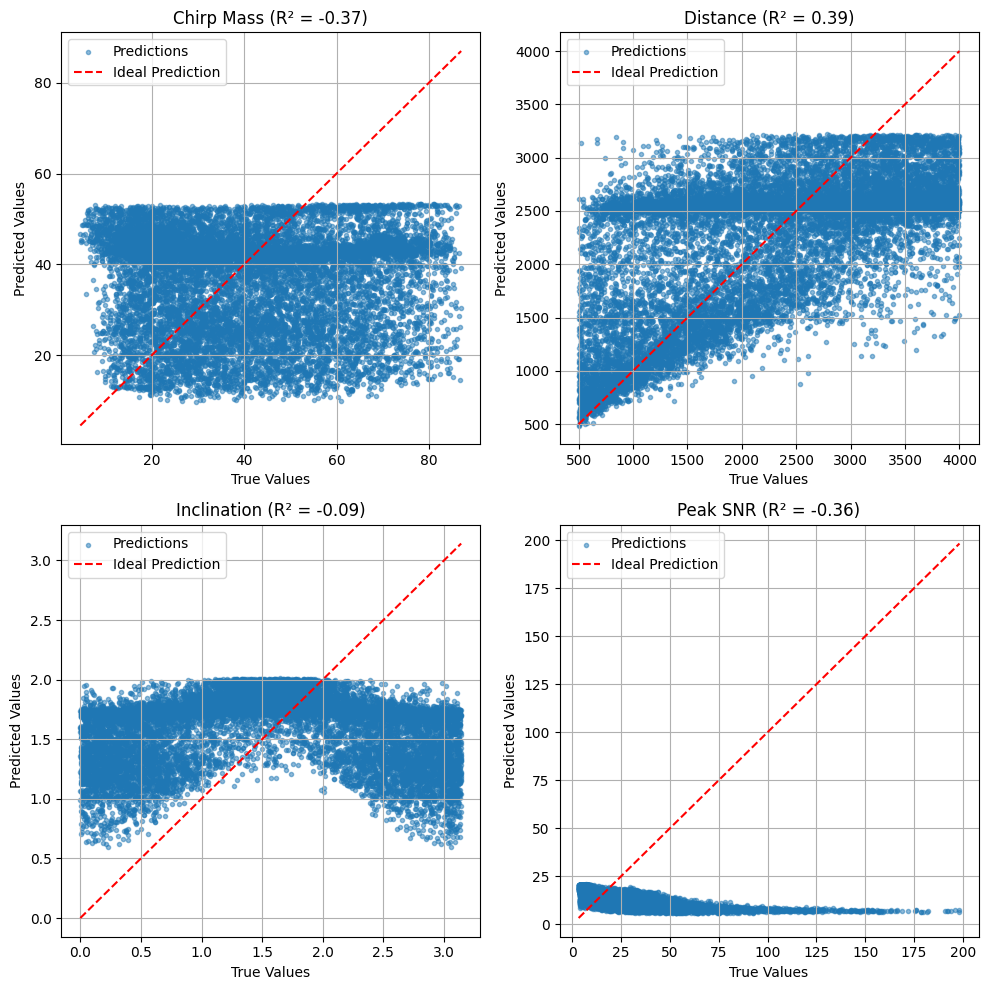

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Set model to evaluation mode
model.eval()

# Store results
predictions = []
true_labels = []

# Disable gradients for evaluation
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to('cuda'), y_test.to('cuda')

        # Get predictions
        outputs = model(X_test)

        # Store predictions and true labels
        predictions.append(outputs.cpu().numpy())
        true_labels.append(y_test.cpu().numpy())

# Convert lists to numpy arrays
predictions = np.concatenate(predictions)
true_labels = np.concatenate(true_labels)

chirp_predictions = predictions[:,0]
distance_predictions = predictions[:,1]
inclination_predictions = predictions[:,2]
peak_snr_predictions = predictions[:,3]

chirp_true_labels = true_labels[:,0]
distance_true_labels = true_labels[:,1]
inclination_true_labels = true_labels[:,2]
peak_snr_true_labels = true_labels[:,3]

chirp_r2 = r2_score(chirp_true_labels, chirp_predictions)
distance_r2 = r2_score(distance_true_labels, distance_predictions)
inclination_r2 = r2_score(inclination_true_labels, inclination_predictions)
peak_snr_r2 = r2_score(peak_snr_true_labels, peak_snr_predictions)
print(f"Chirp Mass R² Score: {chirp_r2:.4f}")
print(f"Distance R² Score: {distance_r2:.4f}")
print(f"Inclination R² Score: {inclination_r2:.4f}")
print(f"Peak SNR R² Score: {peak_snr_r2:.4f}")

# --- PLOTTING ---
# Create figure and axes
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Define data and labels
params = [
    ("Chirp Mass", chirp_predictions, chirp_true_labels, chirp_r2),
    ("Distance", distance_predictions, distance_true_labels, distance_r2),
    ("Inclination", inclination_predictions, inclination_true_labels, inclination_r2),
    ("Peak SNR", peak_snr_predictions, peak_snr_true_labels, peak_snr_r2),
]

# Generate scatter plots
for ax, (title, predictions, true_labels, r2) in zip(axes.flat, params):
    ax.scatter(true_labels, predictions, alpha=0.5, marker='.', label="Predictions")
    ax.plot([min(true_labels), max(true_labels)], [min(true_labels), max(true_labels)], 'r--', label="Ideal Prediction")
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")
    ax.set_title(f"{title} (R² = {r2:.2f})")
    ax.grid(True)
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

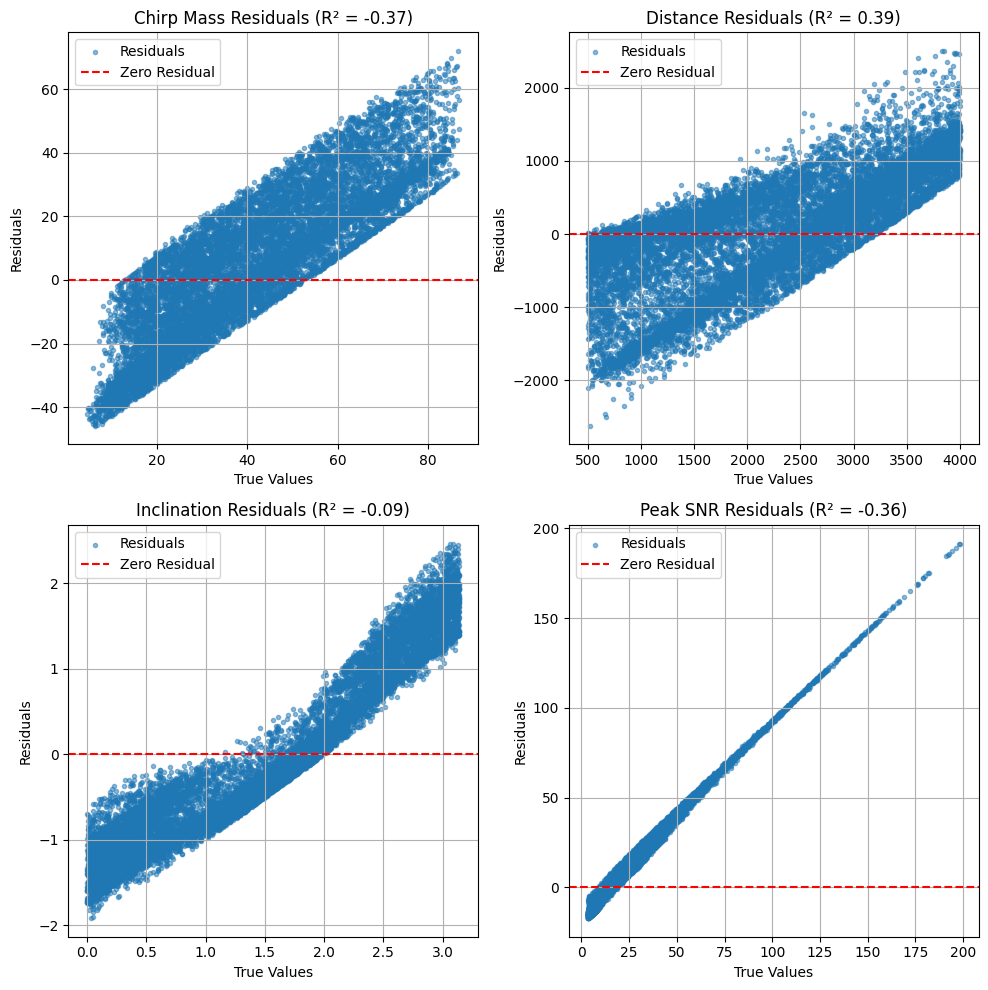

In [56]:
# --- PLOTTING RESIDUALS ---
# Create figure and axes
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Define data and labels
params = [
    ("Chirp Mass", chirp_predictions, chirp_true_labels, chirp_r2),
    ("Distance", distance_predictions, distance_true_labels, distance_r2),
    ("Inclination", inclination_predictions, inclination_true_labels, inclination_r2),
    ("Peak SNR", peak_snr_predictions, peak_snr_true_labels, peak_snr_r2),
]

# Generate residual plots
for ax, (title, predictions, true_labels, r2) in zip(axes.flat, params):
    residuals = true_labels - predictions
    ax.scatter(true_labels, residuals, alpha=0.5, marker='.', label="Residuals")
    ax.axhline(0, color='r', linestyle='--', label="Zero Residual")
    ax.set_xlabel("True Values")
    ax.set_ylabel("Residuals")
    ax.set_title(f"{title} Residuals (R² = {r2:.2f})")
    ax.grid(True)
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

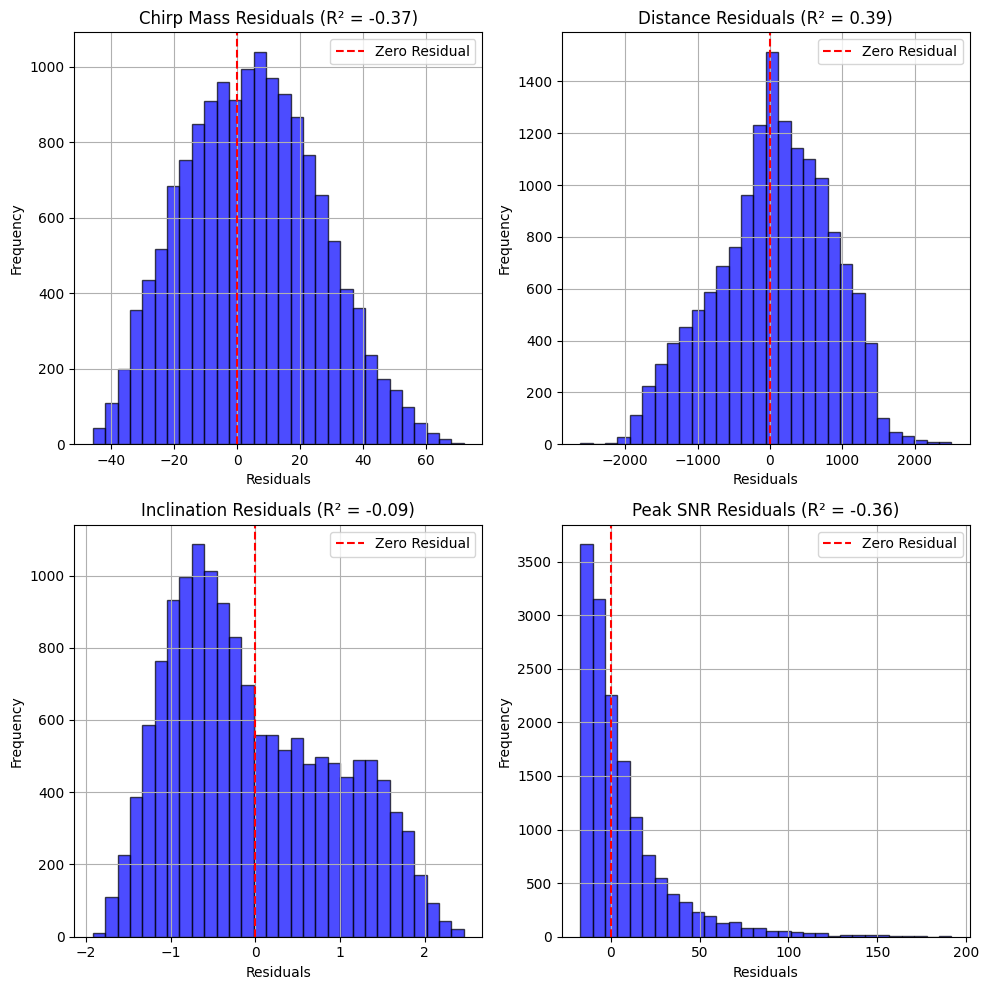

In [57]:
# --- PLOTTING RESIDUAL HISTOGRAMS ---
# Create figure and axes
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Define data and labels
params = [
    ("Chirp Mass", chirp_predictions, chirp_true_labels, chirp_r2),
    ("Distance", distance_predictions, distance_true_labels, distance_r2),
    ("Inclination", inclination_predictions, inclination_true_labels, inclination_r2),
    ("Peak SNR", peak_snr_predictions, peak_snr_true_labels, peak_snr_r2),
]

# Generate histogram plots
for ax, (title, predictions, true_labels, r2) in zip(axes.flat, params):
    residuals = true_labels - predictions
    ax.hist(residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
    ax.axvline(0, color='r', linestyle='--', label="Zero Residual")
    ax.set_xlabel("Residuals")
    ax.set_ylabel("Frequency")
    ax.set_title(f"{title} Residuals (R² = {r2:.2f})")
    ax.grid(True)
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()